In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

### Load Data

In [13]:
data = pd.read_csv(
    "./00- DataSource_APIs/01_data_Nifty50_preprocessed.csv",
    parse_dates=["Datetime"],
    index_col=["Datetime"],
)

data.head()

,Open,High,Low,Close,Month,Week,Day,Day_of_week,Hour,Open_lag_1H,...,Low_lag_24H,Close_lag_24H,Open_window_3H,High_window_3H,Low_window_3H,Close_window_3H,Month_sin,Month_cos,Hour_sin,Hour_cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-07-14 09:15:00+05:30,16018.849609,16070.500000,15995.150391,16048.500000,7,28,14,3,9,15959.750000,...,16103.049805,16129.250000,15959.750000,15982.299805,15955.950195,15975.750000,-0.5,-0.866025,0.631088,-0.775711
2022-07-14 10:15:00+05:30,16049.150391,16052.700195,16003.400391,16005.650391,7,28,14,3,10,16018.849609,...,16056.799805,16077.500000,15979.449870,16011.699870,15969.016927,16000.000000,-0.5,-0.866025,0.398401,-0.917211
2022-07-14 11:15:00+05:30,16005.950195,16005.950195,15937.799805,15956.700195,7,28,14,3,11,16049.150391,...,16066.099609,16084.950195,16009.250000,16035.166667,15984.833659,16009.966797,-0.5,-0.866025,0.136167,-0.990686
2022-07-14 12:15:00+05:30,15957.450195,16002.150391,15942.700195,15972.450195,7,28,14,3,12,16005.950195,...,15990.150391,16001.750000,16024.650065,16043.050130,15978.783529,16003.616862,-0.5,-0.866025,-0.136167,-0.990686
2022-07-14 13:15:00+05:30,15972.299805,15972.299805,15871.750000,15872.299805,7,28,14,3,13,15957.450195,...,15968.500000,15981.799805,16004.183594,16020.266927,15961.300130,15978.266927,-0.5,-0.866025,-0.398401,-0.917211


In [16]:
data.shape

(17503, 37)

### Separate into train and test
I will train the model on a certain portion of the data and leave another part out to evaluate the model.

Because these are time series, I will split based on time. We leave the most recent data as test set.

In [17]:
# Find minimum and maximum dates.

data.index.min(), data.index.max()

(Timestamp('2022-07-14 09:15:00+0530', tz='UTC+05:30'),
 Timestamp('2024-07-12 15:15:00+0530', tz='UTC+05:30'))

In [18]:
# I will keep the last 1 month of data to test
# the forecasting models.

X_train = data[data.index <= "2024-06-10"]
X_test = data[data.index > "2024-06-10"]

X_train.shape, X_test.shape

((16719, 37), (784, 37))

In [20]:
# the target variable
y_train = X_train["Close"].copy()
y_test = X_test["Close"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("Close", axis=1)
X_test = X_test.drop("Close", axis=1)

#### Naive Forecast
- We will predict the pollutant's concentration at time t with its value at time t-1.

- We will use this model as a benchmark.

In [24]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Month', 'Week', 'Day', 'Day_of_week',
       'Hour', 'Open_lag_1H', 'High_lag_1H', 'Low_lag_1H', 'Close_lag_1H',
       'Open_lag_2H', 'High_lag_2H', 'Low_lag_2H', 'Close_lag_2H',
       'Open_lag_4H', 'High_lag_4H', 'Low_lag_4H', 'Close_lag_4H',
       'Open_lag_8H', 'High_lag_8H', 'Low_lag_8H', 'Close_lag_8H',
       'Open_lag_24H', 'High_lag_24H', 'Low_lag_24H', 'Close_lag_24H',
       'Open_window_3H', 'High_window_3H', 'Low_window_3H', 'Close_window_3H',
       'Month_sin', 'Month_cos', 'Hour_sin', 'Hour_cos'],
      dtype='object')

In [25]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["Close_lag_1H"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["Close_lag_1H"], squared=False,))

train rmse:  24.42641769950918
test rmse:  21.6451090544231


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Model-1 - Random Forests


In [37]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=3,
    random_state=0,
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=500, random_state=0)

In [38]:
# Performance of random forests

print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  246.4798626218258
test rmse:  1268.9419626614288


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Model-2 - Linear Regression


In [39]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [40]:
# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  26.04398802581034
test rmse:  27.41208281469023


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The linear regression model provides much better forecasts compared to the benchmark and to random forests.Random Forest regression models are not very good at extrapolating values beyond those observed in the data. 

Text(0, 0.5, 'Importance')

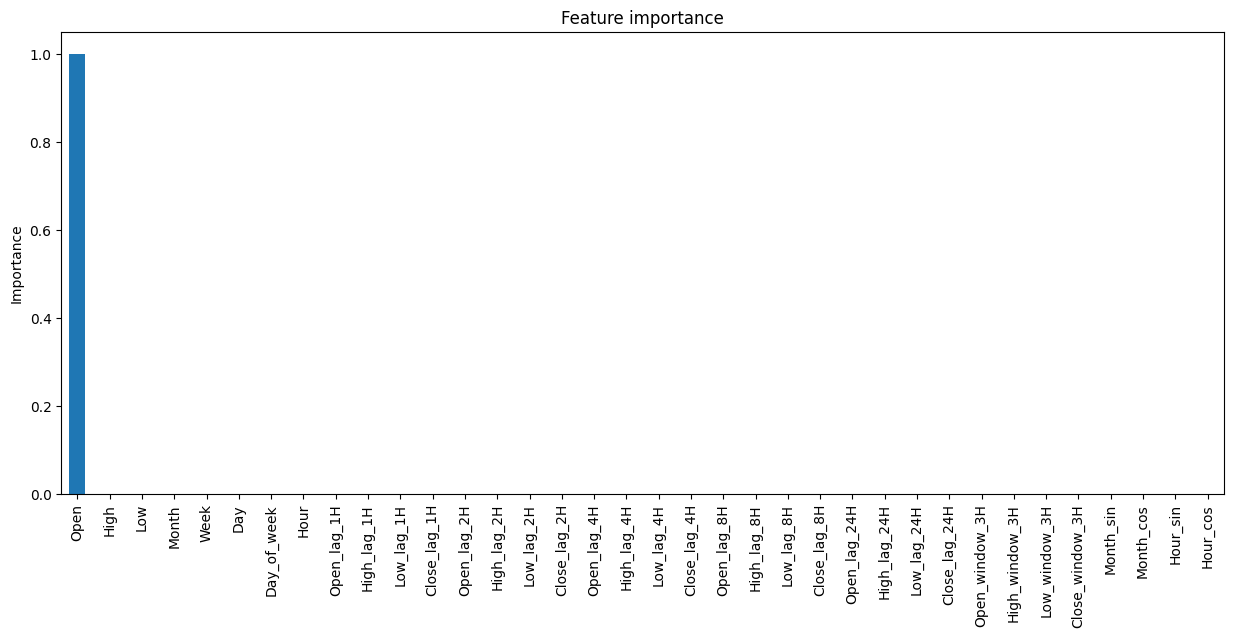

In [41]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")